In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import OpenImageIO as oiio
import numpy as np
import time

# Read image and lut from file

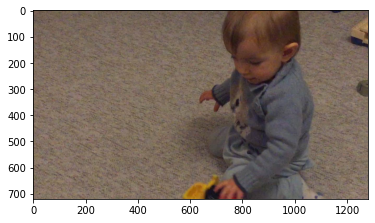

In [2]:
# Read image file with OIIO.ImageBufer
image_path = Path("../../tests/resources/MASA_sequence/MASA_sequence_00196.jpg")
# image_path = Path("./tests/resources/EF_VFX_04/EF_VFX_04_0094901.dpx")
assert image_path.exists()
image = oiio.ImageBuf(str(image_path))
pixels = image.get_pixels().astype(np.float32)

plt.imshow(pixels)
plt.show()

lut dimensions: (32, 32, 32, 3)
lut type: float32


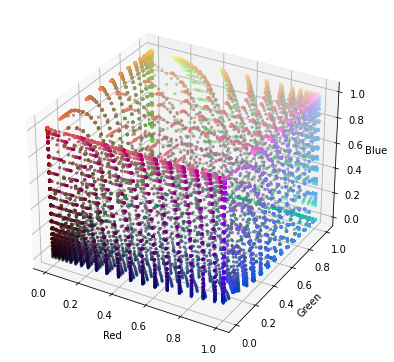

In [3]:
# Read Cube LUT
from pathlib import Path
import numpy as np
import cv2

lut_path = Path("../../tests/resources/AlexaV3_K1S1_LogC2Video_Rec709_EE_aftereffects3d.cube")
# lut_path = Path("../../tests/resources/IdentityLUT.CUBE")
assert lut_path.exists()

data = []
size = -1
for line in lut_path.read_text().split("\n"):
    if line.strip() == "":
        continue
    elif line[0] == "#":
        continue
    elif line.split()[0] == "LUT_1D_SIZE":
        size = int( line.split()[1] )
        kind = "1D"
    elif line.split()[0] == "LUT_3D_SIZE":
        size = int( line.split()[1] )
        kind = "3D"
    else:
        data.append( [float(part) for part in line.split()] )

lut = np.array(data).reshape(size, size, size, 3).astype(np.float32)

print("lut dimensions:", lut.shape)
print("lut type:", lut.dtype)

# plot lut
fig = plt.figure(figsize=[6.4, 6.4])
ax = fig.add_subplot(projection='3d')

xs = []
ys = []
zs = []
colors = []
step = 1
for x in range(0,lut.shape[0], step):
    for y in range(0,lut.shape[1], step):
        for z in range(0,lut.shape[2], step):
            r,g,b = lut[x,y,z]
            xs.append(r)
            ys.append(g)
            zs.append(b)
            colors.append( (x/lut.shape[0],y/lut.shape[1],z/lut.shape[2]) )

ax.scatter(xs, ys, zs, marker='.', c=colors)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.show()


# Apply LUT

## Native python

9.06s


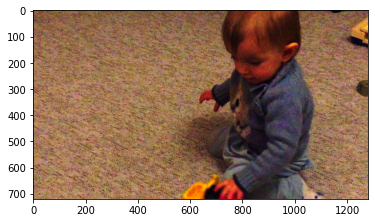

In [14]:
# apply lut with naive python
def apply_lut_python(pixels, lut):
    dst = np.zeros(pixels.shape)
    for i in range( pixels.shape[1]*pixels.shape[0] ):
        x = i%pixels.shape[1]
        y = i//pixels.shape[1]

        # get src color
        r,g,b = pixels[y,x]

        # lookup color
        ri = r*(lut.shape[0]-1)
        gi = g*(lut.shape[1]-1)
        bi = b*(lut.shape[2]-1)
        
        colored = lut[int(bi),int(gi),int(ri)]
        dst[y,x] = colored

    return dst

begin = time.time()
dst = apply_lut_python(pixels, lut)
end = time.time()

dt = end-begin

BASELINE = dt
print("{:.2f}s".format(dt))
plt.imshow(dst)
plt.show()

## Numba

8.76s


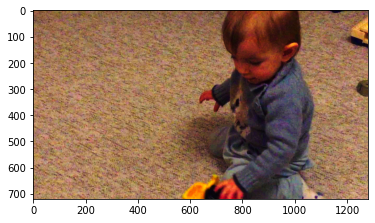

In [8]:
from numba import jit, prange
from math import floor

@jit(nopython=True)
def apply_lut_numba(pixels, lut):
    dst = np.zeros(pixels.shape)
    height, width, channels = pixels.shape
    Z, Y, X, channels = lut.shape
    for i in prange( width*height ):
        u = i%width
        v = i//width

        # get src color
        x = pixels[v,u,0] * X
        y = pixels[v,u,1] * Y
        z = pixels[v,u,2] * Z

        # lookup cube coordinates
        x0 = floor( x )
        x1 = x0+1
        y0 = floor( y )
        y1 = y0+1
        z0 = floor( z )
        z1 = z0+1

        xd = (x-x0)/(x1-x0)
        yd = (y-y0)/(y1-y0)
        zd = (z-z0)/(z1-z0)
        
        # Trilinear Interpolation
        #  blue
        c00 = lut[z0, y0, x0, 0]*(1-xd) + lut[z0, y0, x1, 0]*xd
        c01 = lut[z1, y0, x0, 0]*(1-xd) + lut[z1, y0, x1, 0]*xd
        c10 = lut[z0, y1, x0, 0]*(1-xd) + lut[z0, y1, x1, 0]*xd
        c11 = lut[z1, y1, x0, 0]*(1-xd) + lut[z1, y1, x1, 0]*xd

        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd

        c_blue = c0*(1-zd) + c1*zd

        #  green
        c00 = lut[z0, y0, x0, 1]*(1-xd) + lut[z0, y0, x1, 1]*xd
        c01 = lut[z1, y0, x0, 1]*(1-xd) + lut[z1, y0, x1, 1]*xd
        c10 = lut[z0, y1, x0, 1]*(1-xd) + lut[z0, y1, x1, 1]*xd
        c11 = lut[z1, y1, x0, 1]*(1-xd) + lut[z1, y1, x1, 1]*xd

        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd

        c_green = c0*(1-zd) + c1*zd

        #  red
        c00 = lut[z0, y0, x0, 2]*(1-xd) + lut[z0, y0, x1, 2]*xd
        c01 = lut[z1, y0, x0, 2]*(1-xd) + lut[z1, y0, x1, 2]*xd
        c10 = lut[z0, y1, x0, 2]*(1-xd) + lut[z0, y1, x1, 2]*xd
        c11 = lut[z1, y1, x0, 2]*(1-xd) + lut[z1, y1, x1, 2]*xd

        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd

        c_red = c0*(1-zd) + c1*zd

        # set destination color
        dst[v,u,0] = c_blue
        dst[v,u,1] = c_green
        dst[v,y,2] = c_red

    return dst

begin = time.time()
dst = apply_lut_python(pixels, lut)
end = time.time()

dt = end-begin

print("{:.2f}s".format(dt))
plt.imshow(dst)
plt.show()

## Numpy

1.44s 8x


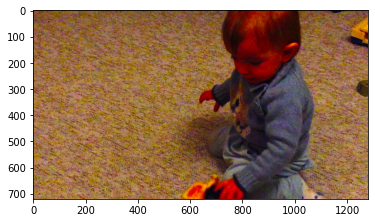

In [28]:
# Create Cube LUT Interpolator for numpy
def create_lut_numpy(lut):
    assert lut.shape[0]==lut.shape[1]==lut.shape[2] and lut.shape[3]==3

    # lut values
    rlut = lut[:,:,:,0].copy(order='C')
    glut = lut[:,:,:,1].copy(order='C')
    blut = lut[:,:,:,2].copy(order='C')

    # th.copy(order='C')e grid coordinates
    x = np.linspace(0,1,32)
    y = np.linspace(0,1,32)
    z = np.linspace(0,1,32)
    xyz = np.array([x,y,z])

    from scipy.interpolate import RegularGridInterpolator

    interpolator_red = RegularGridInterpolator(xyz, rlut, method='linear')
    interpolator_green = RegularGridInterpolator(xyz, glut, method='linear')
    interpolator_blue = RegularGridInterpolator(xyz, blut, method='linear')

    return interpolator_red, interpolator_green, interpolator_blue

# Apply lut to each channel
import cv2
import time
assert len(pixels.shape)==3 and pixels.shape[2]==3

def apply_lut_numpy(pixels, interpolators):
    r = interpolators[0](pixels)
    g = interpolators[1](pixels)
    b = interpolators[2](pixels)

    # concatenate final values
    return cv2.merge([b,g,r])

# -- maim --
interpolators = create_lut_numpy(lut)
begin = time.time()
# interpolate each channel on each RGB grids
rgbs = apply_lut_numpy(pixels, interpolators)
end = time.time()
dt = end-begin
print("{:.2f}s {:.0f}x".format(dt, BASELINE/dt))
plt.imshow(rgbs)
plt.show()

## OCIO

In [43]:
# Apply lut with OCIO
import OpenImageIO as oiio
from pathlib import Path

# read
path = "E:/localize/EF_VFX_04/EF_VFX_04_0093778.dpx"
path = "C:/Users/andris/Pictures/masa 0115.jpg"
inputImage = oiio.ImageBuf( path )

# process
src = oiio.ImageBufAlgo.colorconvert(inputImage, "linear", "sRGB")
spec = oiio.ImageSpec (inputImage.spec().width, inputImage.spec().height, inputImage.spec().nchannels, oiio.UINT8)
dst = oiio.ImageBuf(spec)
assert oiio.ImageBufAlgo.ociodisplay(dst, src, "sRGB", "Film", "Inf")

plt.imshow(dst.get_pixels())
plt.show()

AssertionError: 

## CYTHON

In [10]:
%load_ext Cython

In [11]:
%%cython -a
import numpy as np
cimport numpy as np
from cython cimport boundscheck, wraparound, nonecheck, cdivision
from libc.math cimport floor, ceil, round

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

@boundscheck(False)
@wraparound(False)
@nonecheck(False)
@cdivision(True)
def apply_lut_cython(np.ndarray[DTYPE_t, ndim=3] pixels, np.ndarray[DTYPE_t, ndim=4] lut):
    # pixels variables
    cdef int height = pixels.shape[0]
    cdef int width = pixels.shape[1]
    cdef int channels = pixels.shape[2]
    cdef int i, u, v, count

    # lut variables
    cdef int X = lut.shape[0]
    cdef int Y = lut.shape[1]
    cdef int Z = lut.shape[2]
    
    # result
    cdef np.ndarray[DTYPE_t, ndim=3] dst

    # interpolation definitions
    cdef DTYPE_t x,y,z
    cdef int x0, y0, z0, x1, y1, z1
    cdef DTYPE_t xd, yd, zd, c00, c01, c10, c11, c0, c1, c_blue, c_green, c_red

    dst = np.empty( (height, width, channels), dtype=DTYPE )

    for i in range(width * height):
        u = i%width
        v = i//width

        # get src color
        x = pixels[v,u,0] * X
        y = pixels[v,u,1] * Y
        z = pixels[v,u,2] * Z

        # lookup cube coordinates
        x0 = <int>floor( x )
        x1 = x0+1
        y0 = <int>floor( y )
        y1 = y0+1
        z0 = <int>floor( z )
        z1 = z0+1

        xd = (x-x0)/(x1-x0)
        yd = (y-y0)/(y1-y0)
        zd = (z-z0)/(z1-z0)
        
        # Trilinear Interpolation
        #  blue
        c00 = lut[z0, y0, x0, 0]*(1-xd) + lut[z0, y0, x1, 0]*xd
        c01 = lut[z1, y0, x0, 0]*(1-xd) + lut[z1, y0, x1, 0]*xd
        c10 = lut[z0, y1, x0, 0]*(1-xd) + lut[z0, y1, x1, 0]*xd
        c11 = lut[z1, y1, x0, 0]*(1-xd) + lut[z1, y1, x1, 0]*xd

        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd

        c_blue = c0*(1-zd) + c1*zd

        #  green
        c00 = lut[z0, y0, x0, 1]*(1-xd) + lut[z0, y0, x1, 1]*xd
        c01 = lut[z1, y0, x0, 1]*(1-xd) + lut[z1, y0, x1, 1]*xd
        c10 = lut[z0, y1, x0, 1]*(1-xd) + lut[z0, y1, x1, 1]*xd
        c11 = lut[z1, y1, x0, 1]*(1-xd) + lut[z1, y1, x1, 1]*xd

        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd

        c_green = c0*(1-zd) + c1*zd

        #  red
        c00 = lut[z0, y0, x0, 2]*(1-xd) + lut[z0, y0, x1, 2]*xd
        c01 = lut[z1, y0, x0, 2]*(1-xd) + lut[z1, y0, x1, 2]*xd
        c10 = lut[z0, y1, x0, 2]*(1-xd) + lut[z0, y1, x1, 2]*xd
        c11 = lut[z1, y1, x0, 2]*(1-xd) + lut[z1, y1, x1, 2]*xd

        c0 = c00*(1-yd) + c10*yd
        c1 = c01*(1-yd) + c11*yd

        c_red = c0*(1-zd) + c1*zd

        # set destination color
        dst[v,u,0] = c_blue
        dst[v,u,1] = c_green
        dst[v,u,2] = c_red

    return dst

pixels: float32
lut:    float32
0.064s


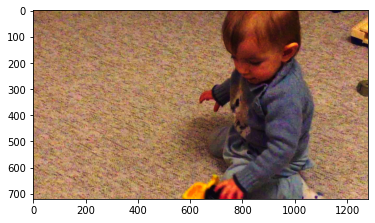

In [12]:

print("pixels:", pixels.dtype)
print("lut:   ", lut.dtype)

begin = time.time()
dst = apply_lut_cython(pixels, lut)
end = time.time()
dt = end-begin

print("{:.3f}s".format(dt))
plt.imshow(dst)
plt.show()

# BENCHMARKS

In [16]:
import time

test_pixels = np.random.random( (2480, 4096, 3) ).astype(np.float32)

# b = time.time()
# apply_lut_python(test_pixels, lut)
# print("python: {:2.3f}s".format(time.time()-b))

b = time.time()
apply_lut_numba(test_pixels, lut)
print("numba:  {:2.3f}s".format(time.time()-b))

# b = time.time()
# apply_lut_numpy(test_pixels, lut)
# print("numpy: {}s".format(time.time()-b))

b = time.time()
apply_lut_cython(test_pixels, lut)
print("cython: {:2.3f}s".format(time.time()-b))

cython: 0.717s


0.127s


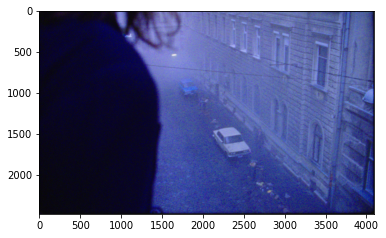

In [37]:
## Read 4K DPX and Apply lut

# Read image file with OIIO.ImageBufer
import OpenImageIO as oiio
from pathlib import Path

dpx_path = Path("../../tests/resources/EF_VFX_04/EF_VFX_04_0094901.dpx")
assert dpx_path.exists()
imageDPX = oiio.ImageBuf(str(dpx_path))
pixelsDPX = imageDPX.get_pixels().astype(np.float32)

# Apply Lut to 4K pixels
b = time.time()
dst = apply_lut_cython(pixelsDPX, lut)
print("{:.3f}s".format(time.time()-b))

import matplotlib.pyplot as plt
plt.imshow(dst)
plt.show()